# Training UNet on Google Colab

In [1]:
# Install necessary libraries (if not already installed)
!pip install tqdm matplotlib torch torchvision

# Mount Google Drive to save checkpoints and data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Import Necessary Modules

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import time

%cd /content/gdrive/MyDrive/StevensIT/EE 628/Final Project

# Import local files (assuming they are uploaded in Colab)
from evaluate import DiceBCELoss  # Define DiceBCELoss in evaluate.py
from unet import UNet  # Define UNet in unet.py
from brain_mri_dataset import BrainMRIDataset  # Define BrainMRIDataset in brain_mri_dataset.py
from data_utils import get_data_loaders  # Define get_data_loaders in data_utils.py

/content/gdrive/MyDrive/StevensIT/EE 628/Final Project


## Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuning
print(f"Using device: {device}")

batch_size = 10
learning_rate = 0.0001
num_epochs = 25
checkpoint_dir = "UNet_checkpoints"  # Save checkpoints to Google Drive

# Ensure the checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

Using device: cuda


## Initialize Dataset and Dataloaders

In [4]:
dataset_path = './data/lgg-mri-segmentation/kaggle_3m'  # Path to dataset in Google Drive
preload = False
dataset = BrainMRIDataset(root_path=dataset_path, preload=preload)
train_loader, val_loader = get_data_loaders(dataset, batch_size=batch_size, train_size=0.9, preload=preload)
print(len(train_loader))
print(len(val_loader))

354
40


## Initialize Model, Loss Function, and Optimizer

In [5]:
model = UNet(in_channels=3, num_classes=1)  # Adjust channels as needed
model.to(device)
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

UNet(
  (encoder1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-

## Training Loop

In [6]:
# Initialize lists to store losses for plotting
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_start_time = time.time()

    # Training
    model.train()
    running_train_loss = []
    train_progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, masks in train_progress_bar:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss.append(loss.item())
        train_progress_bar.set_postfix({"Batch Loss": loss.item()})

    # Validation
    model.eval()
    running_val_loss = []
    val_progress_bar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for images, masks in val_progress_bar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_val_loss.append(loss.item())
            val_progress_bar.set_postfix({"Batch Loss": loss.item()})

    # Compute average losses
    epoch_train_loss = np.mean(running_train_loss)
    train_loss_history.append(epoch_train_loss)
    print(f"Training Loss: {epoch_train_loss:.4f}")

    epoch_val_loss = np.mean(running_val_loss)
    val_loss_history.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss:.4f}")

    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': epoch_train_loss,
        'val_loss': epoch_val_loss,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Timing
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch duration: {epoch_duration:.2f} seconds\n")

print("Training completed!")

Epoch 1/25


Training Loss: 0.6514
Validation Loss: 0.5901
Checkpoint saved: UNet_checkpoints/unet_epoch_1.pth
Epoch duration: 424.84 seconds

Epoch 2/25


Training Loss: 0.5465
Validation Loss: 0.5059
Checkpoint saved: UNet_checkpoints/unet_epoch_2.pth
Epoch duration: 28.87 seconds

Epoch 3/25


Training Loss: 0.4794
Validation Loss: 0.4416
Checkpoint saved: UNet_checkpoints/unet_epoch_3.pth
Epoch duration: 30.23 seconds

Epoch 4/25


Training Loss: 0.4061
Validation Loss: 0.3558
Checkpoint saved: UNet_checkpoints/unet_epoch_4.pth
Epoch duration: 28.74 seconds

Epoch 5/25


Training Loss: 0.3362
Validation Loss: 0.2992
Checkpoint saved: UNet_checkpoints/unet_epoch_5.pth
Epoch duration: 30.23 seconds

Epoch 6/25


Training Loss: 0.2869
Validation Loss: 0.2671
Checkpoint saved: UNet_checkpoints/unet_epoch_6.pth
Epoch duration: 28.86 seconds

Epoch 7/25


Training Loss: 0.2656
Validation Loss: 0.2521
Checkpoint saved: UNet_checkpoints/unet_epoch_7.pth
Epoch duration: 29.34 seconds

Epoch 8/25


Training Loss: 0.2348
Validation Loss: 0.2183
Checkpoint saved: UNet_checkpoints/unet_epoch_8.pth
Epoch duration: 29.41 seconds

Epoch 9/25


Training Loss: 0.2185
Validation Loss: 0.1980
Checkpoint saved: UNet_checkpoints/unet_epoch_9.pth
Epoch duration: 29.43 seconds

Epoch 10/25


Training Loss: 0.2178
Validation Loss: 0.2066
Checkpoint saved: UNet_checkpoints/unet_epoch_10.pth
Epoch duration: 30.12 seconds

Epoch 11/25


Training Loss: 0.2141
Validation Loss: 0.2240
Checkpoint saved: UNet_checkpoints/unet_epoch_11.pth
Epoch duration: 28.80 seconds

Epoch 12/25


Training Loss: 0.2074
Validation Loss: 0.2086
Checkpoint saved: UNet_checkpoints/unet_epoch_12.pth
Epoch duration: 29.29 seconds

Epoch 13/25


Training Loss: 0.2076
Validation Loss: 0.1864
Checkpoint saved: UNet_checkpoints/unet_epoch_13.pth
Epoch duration: 29.40 seconds

Epoch 14/25


Training Loss: 0.2054
Validation Loss: 0.1888
Checkpoint saved: UNet_checkpoints/unet_epoch_14.pth
Epoch duration: 29.43 seconds

Epoch 15/25


Training Loss: 0.1984
Validation Loss: 0.1872
Checkpoint saved: UNet_checkpoints/unet_epoch_15.pth
Epoch duration: 29.34 seconds

Epoch 16/25


Training Loss: 0.2100
Validation Loss: 0.1762
Checkpoint saved: UNet_checkpoints/unet_epoch_16.pth
Epoch duration: 29.42 seconds

Epoch 17/25


Training Loss: 0.2070
Validation Loss: 0.1788
Checkpoint saved: UNet_checkpoints/unet_epoch_17.pth
Epoch duration: 29.44 seconds

Epoch 18/25


Training Loss: 0.2002
Validation Loss: 0.1771
Checkpoint saved: UNet_checkpoints/unet_epoch_18.pth
Epoch duration: 29.39 seconds

Epoch 19/25


Training Loss: 0.1913
Validation Loss: 0.1811
Checkpoint saved: UNet_checkpoints/unet_epoch_19.pth
Epoch duration: 30.03 seconds

Epoch 20/25


Training Loss: 0.1935
Validation Loss: 0.1719
Checkpoint saved: UNet_checkpoints/unet_epoch_20.pth
Epoch duration: 28.76 seconds

Epoch 21/25


Training Loss: 0.1931
Validation Loss: 0.1702
Checkpoint saved: UNet_checkpoints/unet_epoch_21.pth
Epoch duration: 29.51 seconds

Epoch 22/25


Training Loss: 0.1877
Validation Loss: 0.1734
Checkpoint saved: UNet_checkpoints/unet_epoch_22.pth
Epoch duration: 29.46 seconds

Epoch 23/25


Training Loss: 0.1950
Validation Loss: 0.1830
Checkpoint saved: UNet_checkpoints/unet_epoch_23.pth
Epoch duration: 29.53 seconds

Epoch 24/25


Training Loss: 0.2015
Validation Loss: 0.1675
Checkpoint saved: UNet_checkpoints/unet_epoch_24.pth
Epoch duration: 30.12 seconds

Epoch 25/25


Training Loss: 0.1877
Validation Loss: 0.1707
Checkpoint saved: UNet_checkpoints/unet_epoch_25.pth
Epoch duration: 28.94 seconds

Training completed!


## Plot Losses

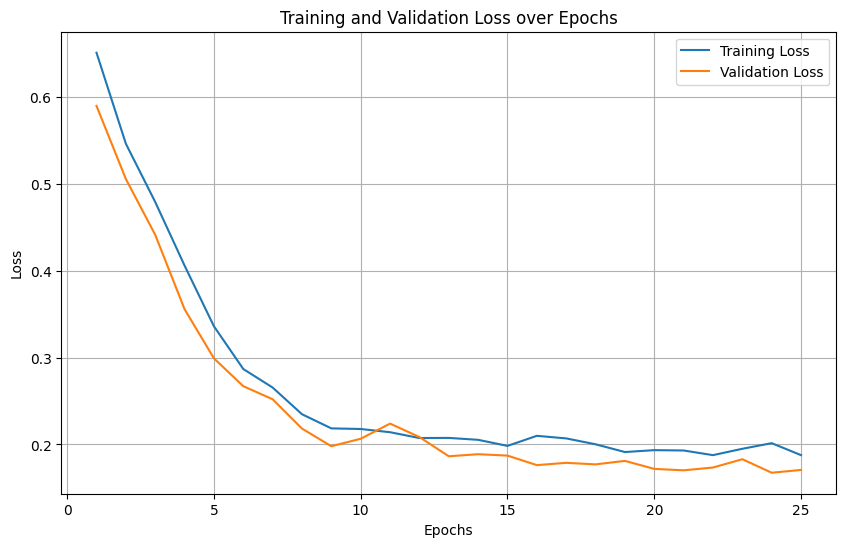

In [7]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.savefig(os.path.join(checkpoint_dir, "loss_plot.png"))  # Save the plot
plt.show()